<a href="https://colab.research.google.com/github/AMEERKOTTA/Deep-Learning-and-Artificial-Intelligence-Tensorflow-2.0/blob/main/Chapter%2006%20%3A%20Recurrent%20Neural%20Networks%2C%20Time%20Series%20and%20Sequence%20Data/18_stock_return_prediction_using_lstm_model_using_all_data_columns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STOCK RETURN PREDICTIONS USING LSTM MODEL**

+ Here we are using all data columns to forecast.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [3]:
## first add the column called previous close
df["PrevClose"] = df["close"].shift(1)
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [4]:
## define the return column.
df["Return"] = (df["close"] - df["PrevClose"]) / df["PrevClose"]
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


<AxesSubplot:>

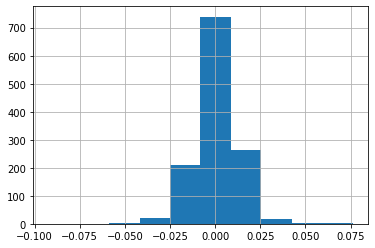

In [5]:
## histogram of the Return Column.
df["Return"].hist()

In [12]:
## turn the full data into numpy array
input_data = df[["open","high","low","close","volume"]].values
targets = df["Return"].values

print(len(input_data))
print(input_data.shape)
print(targets.shape)

1259
(1259, 5)
(1259,)


In [10]:
## now make the actual data which will go to the Neural Network.
T = 10
D = input_data.shape[1]
N = len(input_data) - T
print(D)
print(N)

5
1249


In [15]:
## normalize the inputs
## len of input_data = 1259
## 2/3 of data is taken for training
## and 1/3 is taken for testing.
Ntrain = len(input_data) * 2 // 3
print(Ntrain)

scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)
print(input_data)

839
[[-1.58942908 -1.57081711 -1.57170368 -1.56438486 -0.4813086 ]
 [-1.55633563 -1.57708484 -1.57071748 -1.57558064 -0.88449196]
 [-1.58164238 -1.57563844 -1.56627961 -1.56973937 -0.11862304]
 ...
 [ 1.09795322  1.12286089  1.0565054   1.01599775  1.6465555 ]
 [ 0.91837262  1.10357556  0.95689973  1.10556395  1.97004666]
 [ 1.05415307  1.04282678  1.04368487  0.9936062   1.13738283]]


In [19]:
## setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

print(X_train.shape)
print(Y_train.shape)

(839, 10, 5)
(839,)


In [20]:
## setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

print(X_test.shape)
print(Y_test.shape)

(410, 10, 5)
(410,)


BUILD THE MODEL

In [22]:
i = Input(shape = (T, D))
x = LSTM(50)(i)
x = Dense(1, activation = "sigmoid")(x)
model = Model(i, x)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                11200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


COMPILE THE MODEL

In [23]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = Adam(learning_rate = 0.001),
    metrics = ["accuracy"]
)

TRAIN THE MODEL

In [24]:
r = model.fit(
    X_train, Y_train,
    batch_size = 32,
    epochs = 300,
    validation_data = (X_test, Y_test)
)

Epoch 1/300
27/27 [==============================] - 4s 34ms/step - loss: 0.6977 - accuracy: 0.4827 - val_loss: 0.6932 - val_accuracy: 0.5049
Epoch 2/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6964 - accuracy: 0.4911 - val_loss: 0.6958 - val_accuracy: 0.4902
Epoch 3/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6935 - accuracy: 0.5209 - val_loss: 0.6958 - val_accuracy: 0.4829
Epoch 4/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6923 - accuracy: 0.5292 - val_loss: 0.6932 - val_accuracy: 0.4878
Epoch 5/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6928 - accuracy: 0.5244 - val_loss: 0.6923 - val_accuracy: 0.5244
Epoch 6/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6935 - accuracy: 0.5077 - val_loss: 0.6944 - val_accuracy: 0.4927
Epoch 7/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6916 - accuracy: 0.5280 - val_loss: 0.6980 - val_accuracy: 0.4854
Epoch 

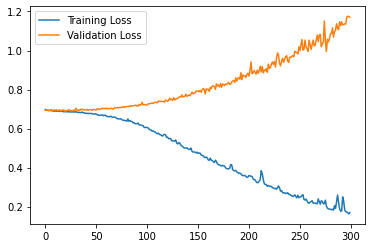

In [25]:
## plot the loss and accuracy
plt.plot(r.history["loss"], label = "Training Loss")
plt.plot(r.history["val_loss"], label = "Validation Loss")
plt.legend();
plt.show();

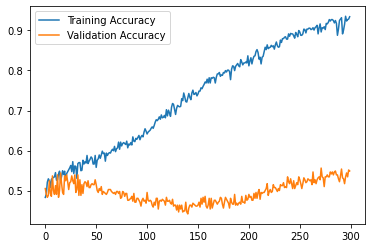

In [26]:
## plot the loss and accuracy
plt.plot(r.history["accuracy"], label = "Training Accuracy")
plt.plot(r.history["val_accuracy"], label = "Validation Accuracy")
plt.legend();
plt.show();

+ Here the training loss is decreasing and validation loss is increasing.
+ And Training Accuracy is Increasing and Validation Accuracy is around 50%.
+ That means the classification model is Worst in predicting the Binary Classification.
+ That means, we are not able to Predict whether the price go up or down.
+ And how come we could predict the exact price where the Price would move.
+ Infact the Proice Fluctuations are really depends on real time events and market participants Emotions.
+ We will not be able to predict the Stock Price by Only Looking at the Price.

***